In [38]:
import os
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = 20,10
import seaborn as sns
from xgboost.sklearn import XGBClassifier
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)

In [15]:
# got this code from here https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 15)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [16]:
df = pd.read_csv("fraud_detection.csv")
y = df["y"]
del df["y"]

## Análise exploratória

In [17]:
df.head()

,MCC,Segmento,AutomaticReceivablesAdvance,DurationEstimate,ActiveMonths,TPV_M1,TPV_M2,TPV_M3,TPV_M4,TPV_M5,TPV_M6,TPV_M7,TPV_M8,TPV_M9,TPV_M10,TPV_M11,TPV_M12,CHARGEBACK_M1,CHARGEBACK_M2,CHARGEBACK_M3,CHARGEBACK_M4,CHARGEBACK_M5,CHARGEBACK_M6,CHARGEBACK_M7,CHARGEBACK_M8,CHARGEBACK_M9,CHARGEBACK_M10,CHARGEBACK_M11,CHARGEBACK_M12,RAV_M1,RAV_M2,RAV_M3,RAV_M4,RAV_M5,RAV_M6,RAV_M7,RAV_M8,RAV_M9,RAV_M10,RAV_M11,RAV_M12
0,5046,Atacadistas Gerais,0,38.341253,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5184.216300,5349.436852,1621.858888,5558.491428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5812,Bares e Restaurantes,0,30.000000,13,439.031469,29167.783361,42252.930754,31907.662750,44533.985926,45549.502248,44595.657026,53305.966513,43209.625187,38094.177727,49315.148376,41309.808009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5661,Vestuário,1,36.964705,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16029.512503,21648.309433,2751.950604,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,9779.179149,12995.126668,1124.090215,0.000000,0.000000
3,5661,Vestuário,0,36.964705,0,0.000000,252.871741,0.000000,0.000000,340.489211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5812,Bares e Restaurantes,1,16.123562,16,81289.169094,125268.351151,101719.617607,61555.732141,61478.061622,80979.127671,63191.415605,52074.635060,46042.685595,44569.761234,61895.563841,42422.146946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40268.801429,69171.996903,45793.215628,35347.459869,28984.60298,45449.931694,33973.019786,26403.729445,23856.130545,25657.237059,29467.042138,22122.950744


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MCC,32000.0,5940.054719,9.652199e+02,7.420000e+02,5499.000000,5812.000000,5948.000000,9.402000e+03
AutomaticReceivablesAdvance,32000.0,0.440688,4.964773e-01,0.000000e+00,0.000000,0.000000,1.000000,1.000000e+00
DurationEstimate,32000.0,37.515373,4.981933e+02,1.000000e+00,22.222909,30.000000,37.713016,5.812500e+04
ActiveMonths,32000.0,10.350625,8.894048e+00,0.000000e+00,1.000000,11.000000,17.000000,5.400000e+01
TPV_M1,32000.0,52737.234749,7.982777e+05,-6.743696e+06,252.677860,12418.035696,36337.352194,8.261028e+07
TPV_M2,32000.0,55443.152255,8.724484e+05,-5.588838e+03,0.000000,13229.150591,38656.108841,8.303176e+07
TPV_M3,32000.0,58686.438775,1.156657e+06,-6.743696e+06,0.000000,11117.825818,34384.411550,1.154858e+08
TPV_M4,32000.0,70078.982898,1.365262e+06,-1.854516e+07,0.000000,11138.478387,37140.218706,1.070562e+08
TPV_M5,32000.0,49112.960302,8.333336e+05,-1.319910e+04,0.000000,9913.275268,33177.395337,9.946952e+07
TPV_M6,32000.0,65178.764927,1.603734e+06,-1.972531e+04,0.000000,9204.748848,32509.761003,1.504687e+08


In [19]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

In [20]:
numeric_features

Index(['MCC', 'AutomaticReceivablesAdvance', 'DurationEstimate',
       'ActiveMonths', 'TPV_M1', 'TPV_M2', 'TPV_M3', 'TPV_M4', 'TPV_M5',
       'TPV_M6', 'TPV_M7', 'TPV_M8', 'TPV_M9', 'TPV_M10', 'TPV_M11', 'TPV_M12',
       'CHARGEBACK_M1', 'CHARGEBACK_M2', 'CHARGEBACK_M3', 'CHARGEBACK_M4',
       'CHARGEBACK_M5', 'CHARGEBACK_M6', 'CHARGEBACK_M7', 'CHARGEBACK_M8',
       'CHARGEBACK_M9', 'CHARGEBACK_M10', 'CHARGEBACK_M11', 'CHARGEBACK_M12',
       'RAV_M1', 'RAV_M2', 'RAV_M3', 'RAV_M4', 'RAV_M5', 'RAV_M6', 'RAV_M7',
       'RAV_M8', 'RAV_M9', 'RAV_M10', 'RAV_M11', 'RAV_M12'],
      dtype='object')

In [21]:
categorical_features

Index(['Segmento'], dtype='object')

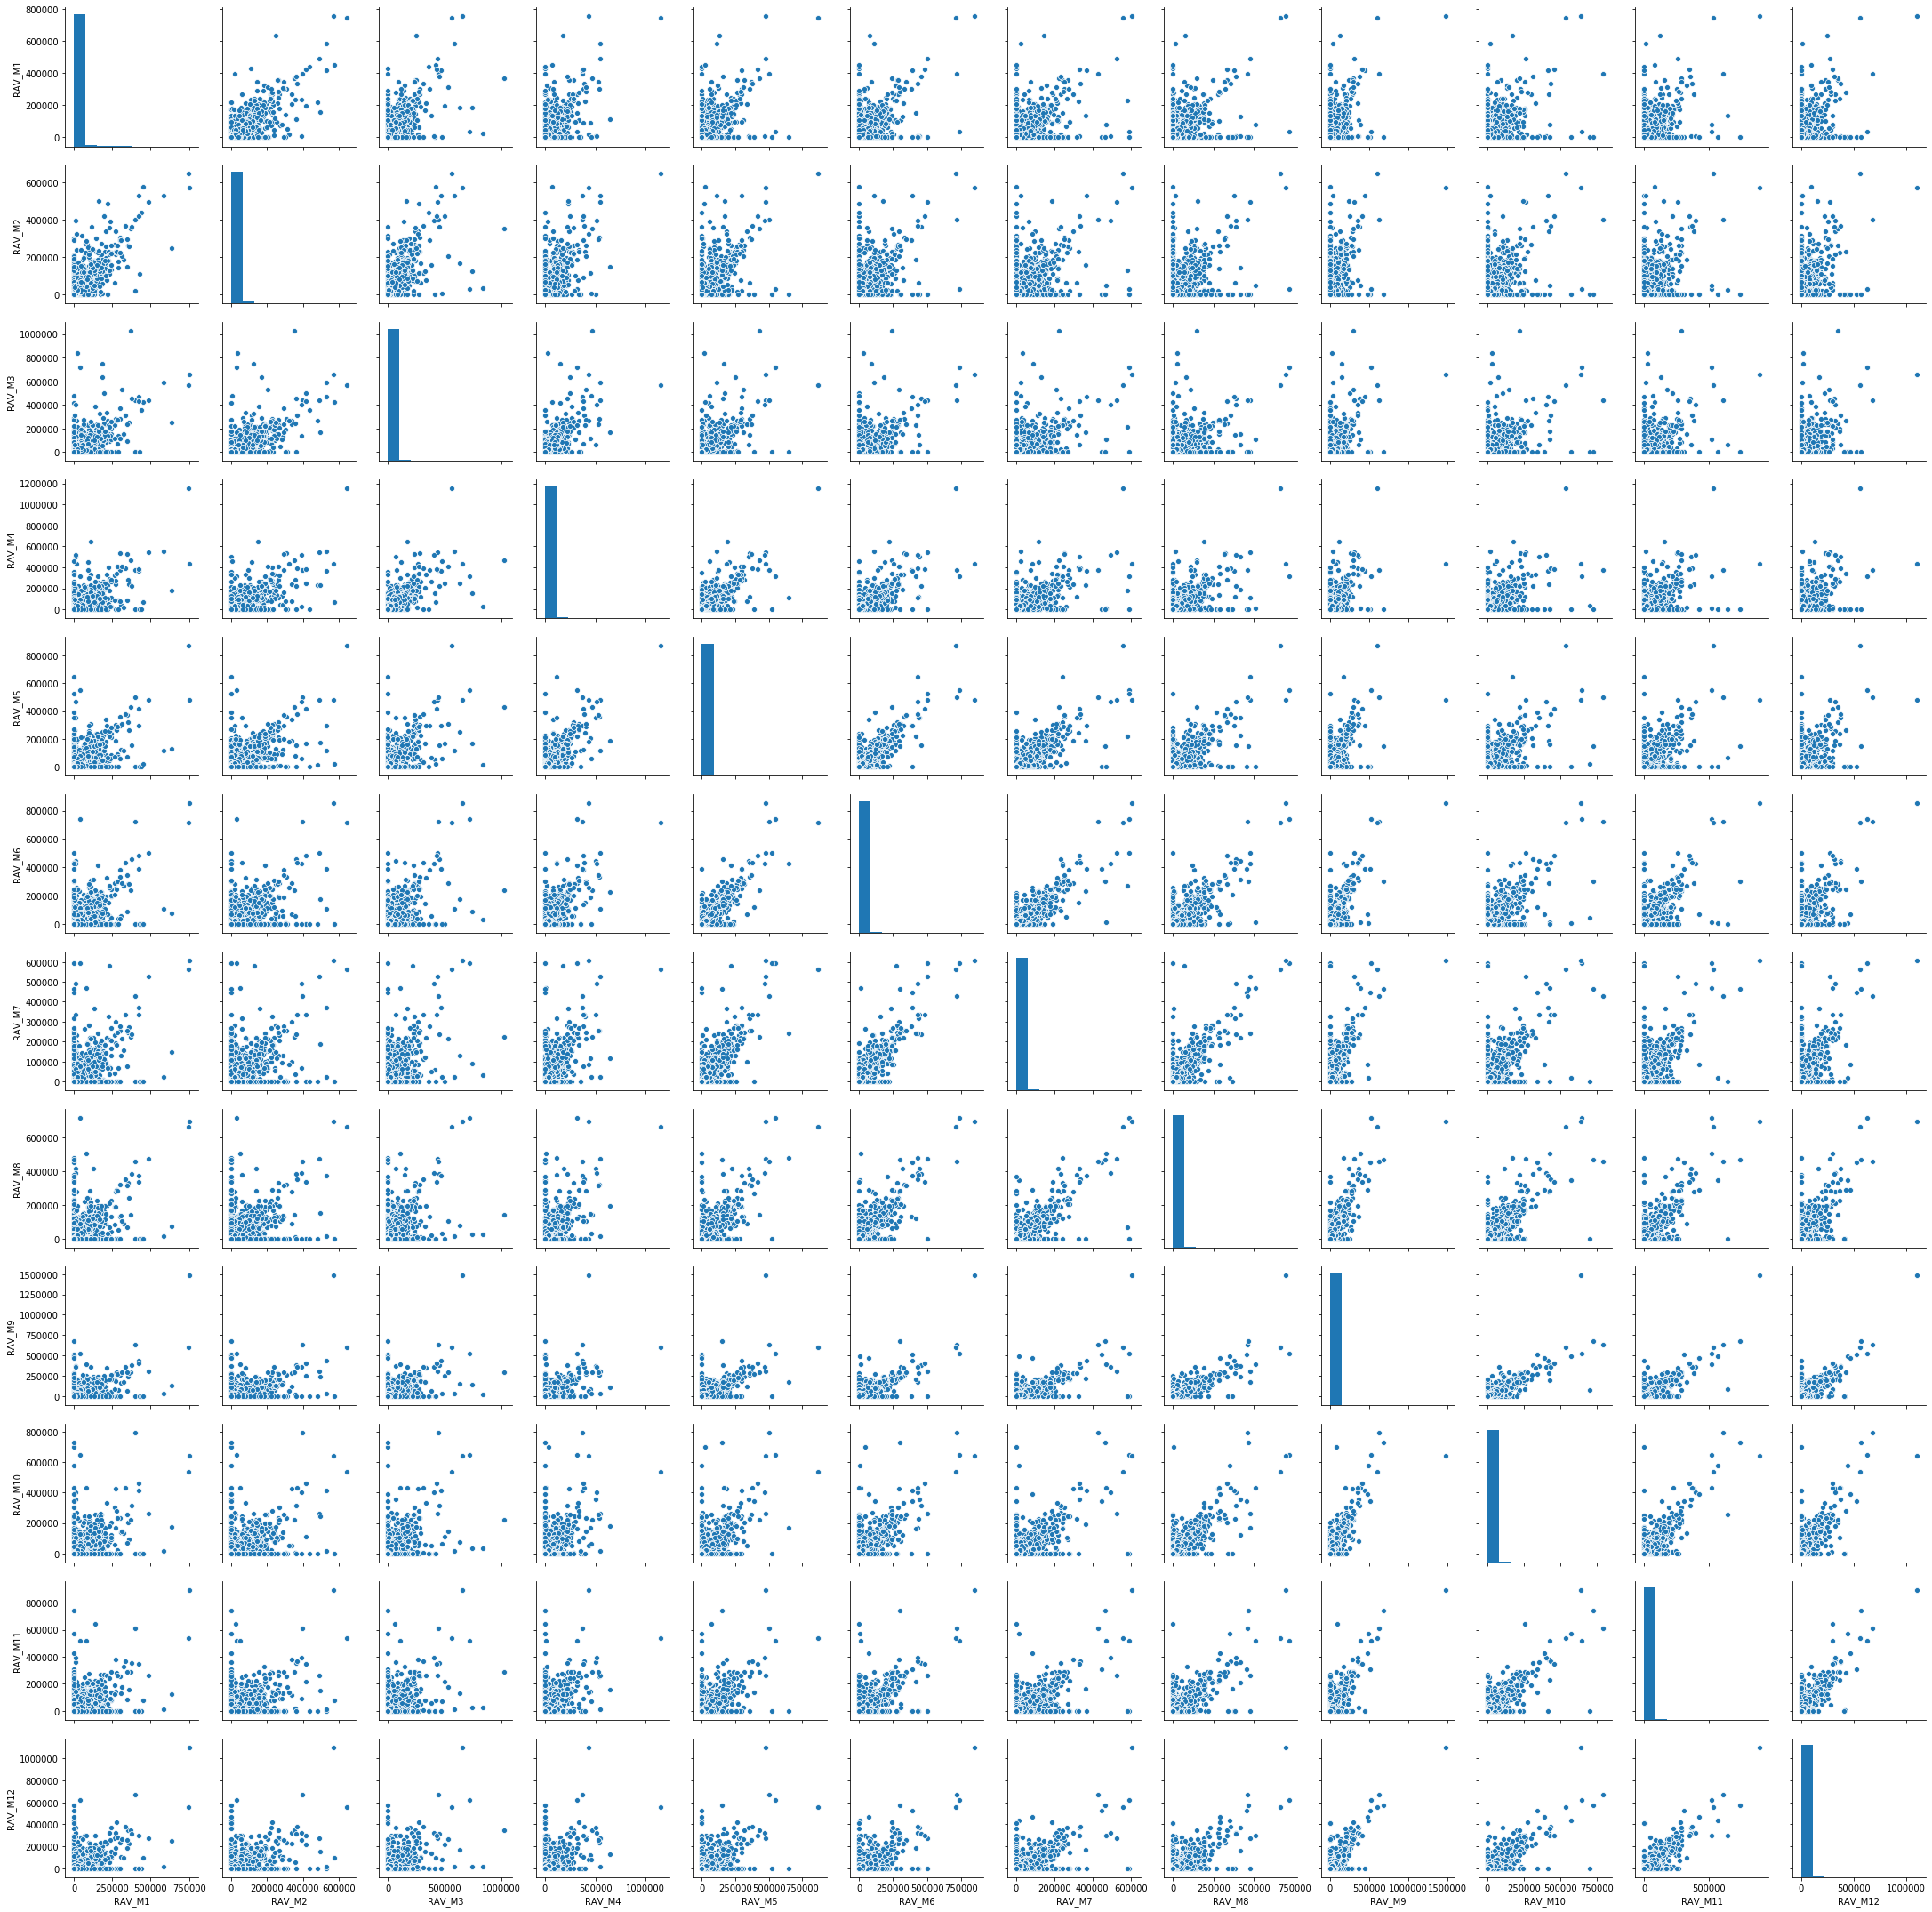

In [37]:
sns.pairplot(df[[ 'RAV_M1', 'RAV_M2', 'RAV_M3', 'RAV_M4', 'RAV_M5', 'RAV_M6', 'RAV_M7',
       'RAV_M8', 'RAV_M9', 'RAV_M10', 'RAV_M11', 'RAV_M12']])


In [22]:
df["Segmento"].value_counts(dropna=False, normalize=True)

Alimentação Rápida        0.206063
Lojas Diversas            0.176781
Bares e Restaurantes      0.103125
Vestuário                 0.099125
Outros                    0.089563
Supermercados             0.062906
Automotivo                0.056313
Saúde                     0.055469
Material de Construção    0.043000
Atacadistas Gerais        0.029125
Postos de Gasolina        0.020500
Educação                  0.019000
Lazer & Turismo           0.018719
Academias                 0.015781
Atacadista de Alimento    0.004531
Name: Segmento, dtype: float64

## Modelagem

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y,
                                                    test_size=0.30, 
                                                    random_state=seed)

In [24]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [25]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 200],
                 "classifier__max_depth":[5, 8, 15, 25, None],
                 "classifier__min_samples_leaf":[1, 2, 5, 10, 100],
                 "classifier__max_leaf_nodes": [2, 5, 10]}]

# Create grid search
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0, n_jobs=-1, scoring='f1') # Fit grid search
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

In [26]:
X_train.columns

Index(['MCC', 'Segmento', 'AutomaticReceivablesAdvance', 'DurationEstimate',
       'ActiveMonths', 'TPV_M1', 'TPV_M2', 'TPV_M3', 'TPV_M4', 'TPV_M5',
       'TPV_M6', 'TPV_M7', 'TPV_M8', 'TPV_M9', 'TPV_M10', 'TPV_M11', 'TPV_M12',
       'CHARGEBACK_M1', 'CHARGEBACK_M2', 'CHARGEBACK_M3', 'CHARGEBACK_M4',
       'CHARGEBACK_M5', 'CHARGEBACK_M6', 'CHARGEBACK_M7', 'CHARGEBACK_M8',
       'CHARGEBACK_M9', 'CHARGEBACK_M10', 'CHARGEBACK_M11', 'CHARGEBACK_M12',
       'RAV_M1', 'RAV_M2', 'RAV_M3', 'RAV_M4', 'RAV_M5', 'RAV_M6', 'RAV_M7',
       'RAV_M8', 'RAV_M9', 'RAV_M10', 'RAV_M11', 'RAV_M12'],
      dtype='object')

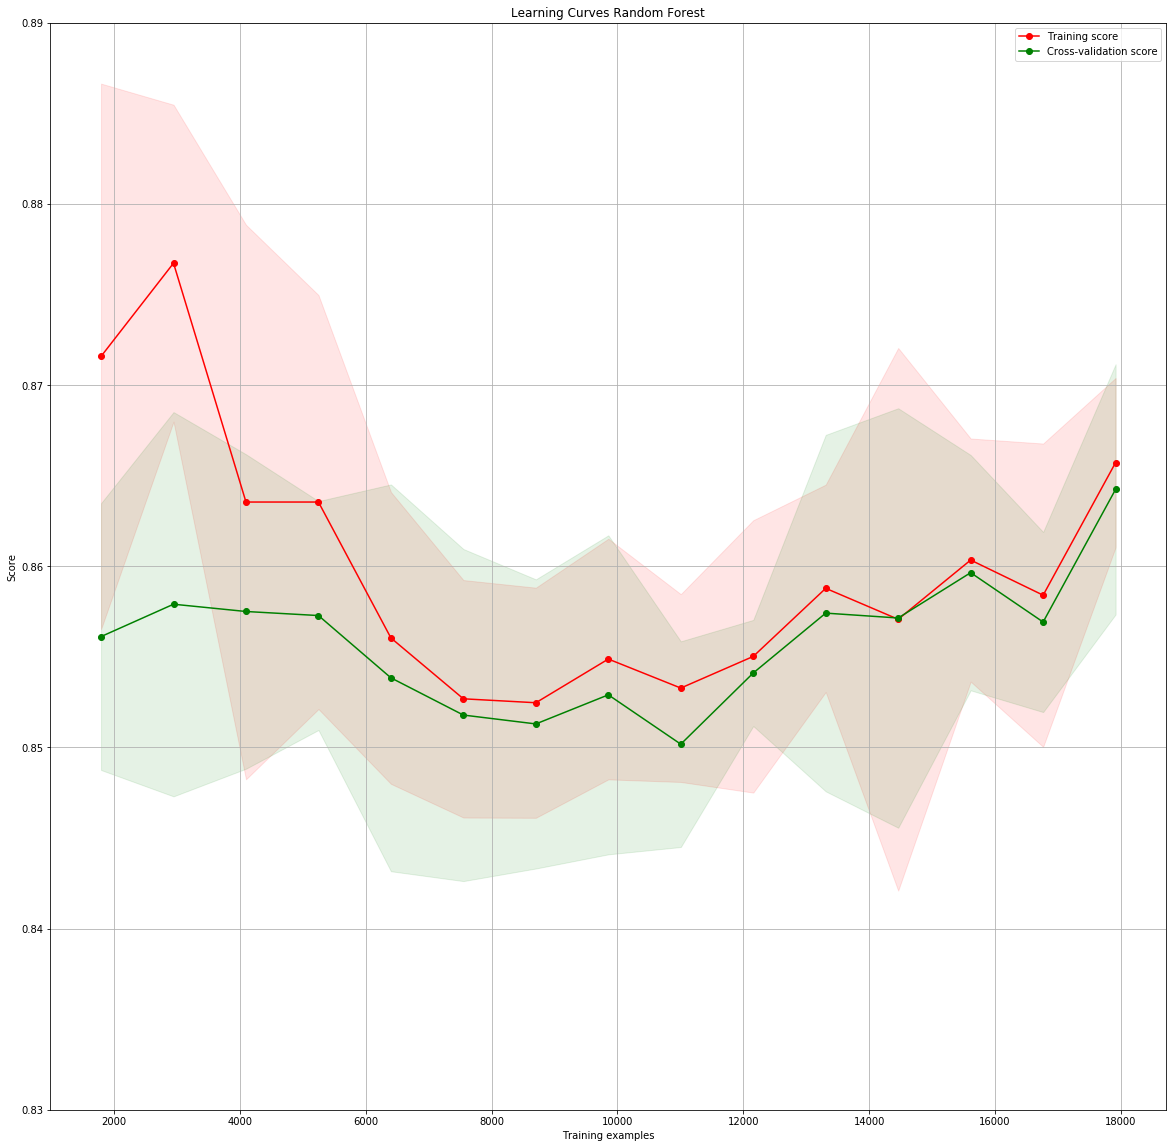

In [27]:
title = "Learning Curves Random Forest"

lc_svm = plot_learning_curve(model, title, X_train, y_train, ylim=(0.83,0.89), cv=5, n_jobs=4)
lc_svm.show()

In [28]:
predicted = model.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83      3713
           1       0.96      0.79      0.87      5887

    accuracy                           0.85      9600
   macro avg       0.85      0.87      0.85      9600
weighted avg       0.87      0.85      0.85      9600



In [29]:
static_params = {'objective':'binary:logistic', 
                 'silent':1}

# # Create dictionary with candidate learning algorithms and their hyperparameters
variable_params = [{"classifier": [XGBClassifier(**static_params)],
                    "classifier__n_estimators": [5, 10, 20, 25],
                    "classifier__max_depth": [2, 4, 6, 10],   
                    "classifier__learning_rate": np.linspace(1e-16, 1 , 3)}]


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(**static_params))])

bst_grid = GridSearchCV(estimator = pipe,
                        param_grid = variable_params,
                        cv=5, 
                        verbose=0, 
                        n_jobs=-1, 
                        scoring='f1')

bst_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                        

In [30]:
print("The mean f1 of the model is:", bst_grid.best_estimator_.score(X_train, y_train))

The mean f1 of the model is: 0.9450892857142857


In [31]:
predicted = bst_grid.best_estimator_.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3713
           1       0.95      0.90      0.93      5887

    accuracy                           0.91      9600
   macro avg       0.90      0.91      0.91      9600
weighted avg       0.91      0.91      0.91      9600



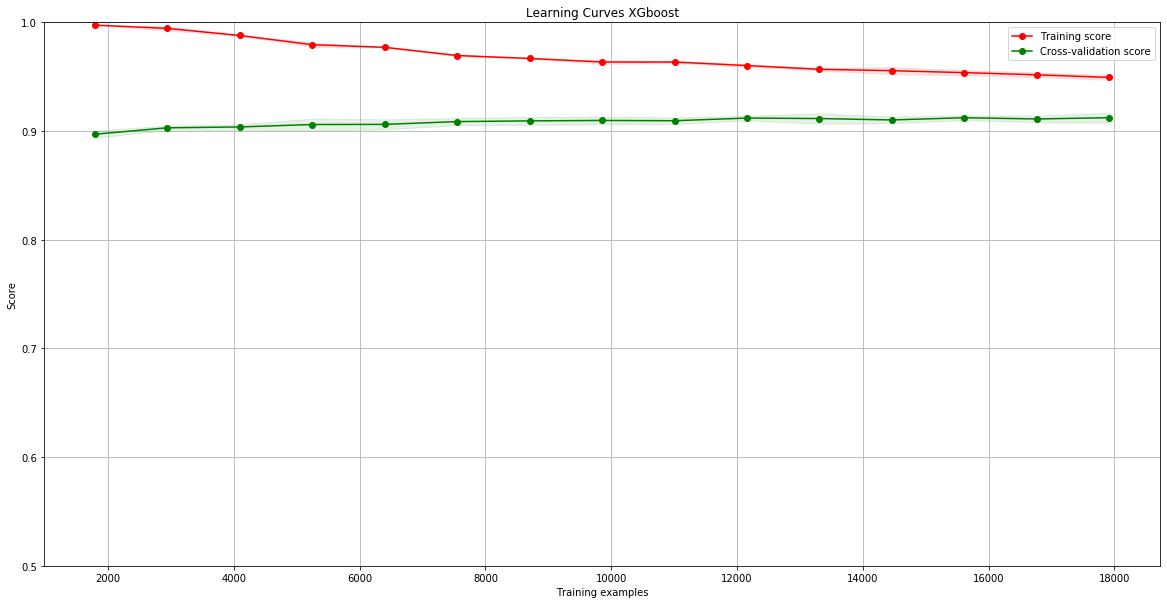

In [39]:
title = "Learning Curves XGboost"

lc_svm = plot_learning_curve(bst_grid.best_estimator_, title, X_train, y_train, ylim=(0.5,1.0), cv=5, n_jobs=4)
lc_svm.show()

In [33]:
bst_grid.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['MCC', 'AutomaticReceivablesAdvance', 'DurationEstimate',
       'ActiveMonths', 'TPV_...
                 XGBClassifier(base_score=